In [1]:
!pip install optuna --quiet

In [2]:
from functools import partial
import os
import tempfile
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchaudio
import torchaudio.transforms as T

import optuna

print(torch.cuda.is_available())

False


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load waveforms and create dataset


def pad_tensor(tensor, target_length):
    # Pad the tensor to the target length
    padding = target_length - tensor.shape[-1]
    if padding > 0:
        tensor = torch.nn.functional.pad(tensor, (0, padding))
    return tensor


def create_tensor_dataset(directories):   # Create labeled tensor dataset from PSUH directory
    # Initialize lists
    audio_tensors = []
    filepaths = []
    for directory in directories:
        for filename in os.listdir(directory):
            try:
                file_path = os.path.join(directory, filename)
                # Load audio file
                waveform, sample_rate = torchaudio.load(filename)
                # Get spectrogram of waveform and transform to tensor
                spectrogram_transform = T.Spectrogram()
                spectrogram = spectrogram_transform(waveform)
                # Add tensor to list
                audio_tensors.append(spectrogram)
                # Add filepath to list
                filepaths.append(file_path)
            except (RuntimeError, OSError) as e:
                print(f"An error occurred with {filename}: {e}")
                continue
            
    # Assign labels based on filepath name (pre = 0, dc = 1, post = 2)
    labels = [0 if 'pre' in s else 1 if 'dc' in s else 2 if 'post' in s else -1 for s in filepaths]

    # Find the maximum length of the waveforms
    max_length = max(waveform.shape[-1] for waveform in audio_tensors)
    # Pad all waveforms to the maximum length
    padded_waveforms = [pad_tensor(waveform, max_length) for waveform in audio_tensors]
    # Convert lists to tensors
    audio_tensors = torch.stack(padded_waveforms)
    labels = torch.tensor(labels)
    # Create TensorDataset
    dataset = TensorDataset(audio_tensors, labels)
    return filepaths, labels, dataset



In [4]:
# Define normalized utterance directories
pre_norm = "PSUH/NR/pre/segment/normalized/"
post_norm = "PSUH/NR/post/segment/normalized/"
dc_norm = "PSUH/NR/dc/segment/normalized/"
directories = [pre_norm, post_norm, dc_norm]
# Create TensorDataset
PSUH_paths, PSUH_labels, PSUH_ds = create_tensor_dataset(directories)
PSUH_ds[0][0].shape

An error occurred with 05pre_nr_10.wav: Error opening '05pre_nr_10.wav': System error.
An error occurred with 17post_nr_1.wav: Error opening '17post_nr_1.wav': System error.
An error occurred with 36dc_nr_3.wav: Error opening '36dc_nr_3.wav': System error.


torch.Size([1, 201, 219])

In [5]:
### Split into train / val / test datasets
# Split indices
train_indices, test_indices = train_test_split(range(len(PSUH_ds)), test_size=0.2, stratify=PSUH_labels, random_state=123)
# Further split train_indices to create a validation dataset that's 25% of training set
train_indices, val_indices = train_test_split(train_indices, test_size=0.2, stratify=PSUH_labels[train_indices], random_state=123)

# Create subsets
train_dataset = Subset(PSUH_ds, train_indices)
val_dataset = Subset(PSUH_ds, val_indices)
test_dataset = Subset(PSUH_ds, test_indices)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Create CNN model

In [6]:
class MultiCNN(nn.Module):
    def __init__(self, l1=4, l2=2):
        super(MultiCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 25 * 27, l1)  # Adjust the dimensions based on the input size
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 3)  # 3 classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 25 * 27)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first fully connected layer
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after second fully connected layer
        x = self.fc3(x)
        return x

# Example usage
model = MultiCNN()
print(model)

MultiCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21600, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [7]:
def objective(trial):
    # Hyperparameters to tune
    l1 = trial.suggest_int('l1', 2, 16)
    l2 = trial.suggest_int('l2', 2, 16)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    
    # Load dataset
    train_dataset = Subset(PSUH_ds, train_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = MultiCNN(l1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop (10 epoch for simplicity)
    model.train()
    for epoch in range(10):
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

In [8]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

[I 2024-10-17 00:32:56,865] A new study created in memory with name: no-name-6bd58de7-a80d-4ad7-bb89-4fd60189932d
[I 2024-10-17 00:33:07,960] Trial 0 finished with value: 1.0249477624893188 and parameters: {'l1': 11, 'l2': 10, 'lr': 1.6898409374005797e-05}. Best is trial 0 with value: 1.0249477624893188.
[I 2024-10-17 00:33:19,260] Trial 1 finished with value: 1.074440598487854 and parameters: {'l1': 6, 'l2': 7, 'lr': 0.00014207347165889498}. Best is trial 0 with value: 1.0249477624893188.
[I 2024-10-17 00:33:30,957] Trial 2 finished with value: 0.8051438927650452 and parameters: {'l1': 13, 'l2': 15, 'lr': 0.0046050959848751485}. Best is trial 2 with value: 0.8051438927650452.
[I 2024-10-17 00:33:42,082] Trial 3 finished with value: 1.43328857421875 and parameters: {'l1': 4, 'l2': 8, 'lr': 4.271753275047635e-05}. Best is trial 2 with value: 0.8051438927650452.
[I 2024-10-17 00:33:53,299] Trial 4 finished with value: 1.1141152381896973 and parameters: {'l1': 11, 'l2': 8, 'lr': 0.0002667

Best Hyperparameters: {'l1': 13, 'l2': 15, 'lr': 0.0046050959848751485}


In [10]:
model = MultiCNN(l1=13, l2=15)
print(model)

MultiCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=21600, out_features=13, bias=True)
  (fc2): Linear(in_features=13, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch 1/30, Training Loss: 1.1284, Validation Loss: 1.0022, Training Accuracy: 52.802%, Validation Accuracy: 63.248%
Epoch 2/30, Training Loss: 0.98352, Validation Loss: 0.94271, Training Accuracy: 63.147%, Validation Accuracy: 63.248%
Epoch 3/30, Training Loss: 0.96083, Validation Loss: 0.92035, Training Accuracy: 62.931%, Validation Accuracy: 63.248%
Epoch 4/30, Training Loss: 0.93793, Validation Loss: 0.88198, Training Accuracy: 63.793%, Validation Accuracy: 64.103%
Epoch 5/30, Training Loss: 0.93297, Validation Loss: 0.88772, Training Accuracy: 63.362%, Validation Accuracy: 64.103%
Epoch 6/30, Training Loss: 0.92351, Validation Loss: 0.88873, Training Accuracy: 63.793%, Validation Accuracy: 63.248%
Epoch 7/30, Training Loss: 0.89589, Validation Loss: 0.88916, Training Accuracy: 64.44%, Validation Accuracy: 63.248%
Epoch 8/30, Training Loss: 0.94194, Validation Loss: 0.89382, Training Accuracy: 62.931%, Validation Accuracy: 63.248%
Epoch 9/30, Training Loss: 0.89841, Validation Loss

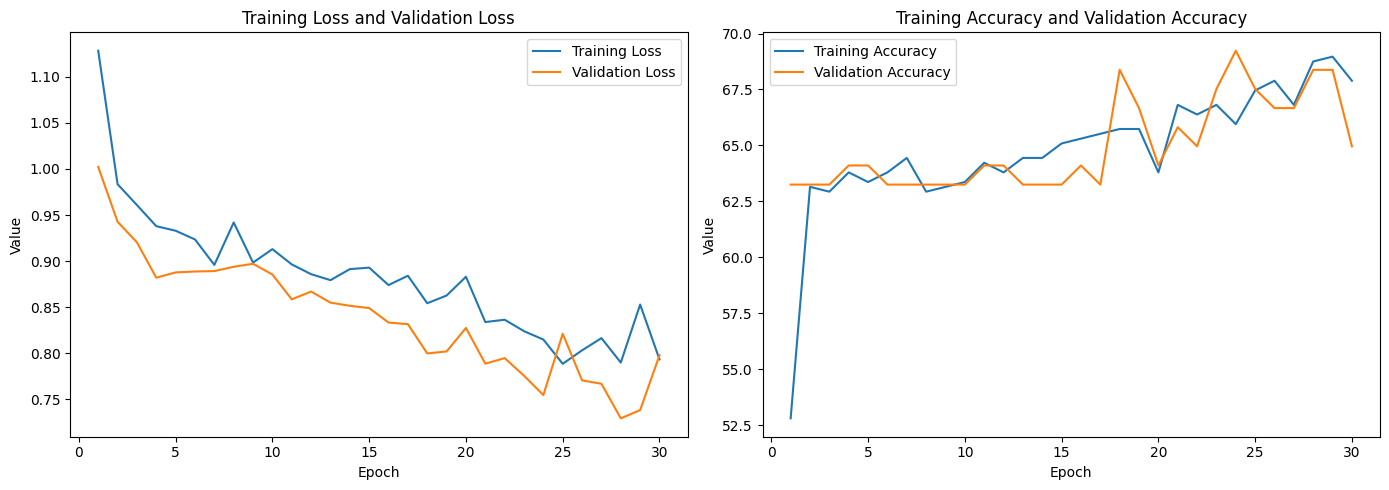

In [11]:
# Set loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0046)

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * train_correct / train_total)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {(running_loss/len(train_loader)):.5g}, Validation Loss: {(val_loss/len(val_loader)):.5g}, Training Accuracy: {(100 * train_correct / train_total):.5g}%, Validation Accuracy: {(100 * val_correct / val_total):.5g}%')

# Plotting the results
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def evaluate_dataset(dataset_loader, model=model):
    model.eval()
    
    correct = 0
    total = 0
    incorrect_idx_dataset = []
    correct_idx_dataset = []
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for batch_idx, (inputs, labels) in enumerate(dataset_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            # Collect correct and incorrect indices
            for i, (pred, label) in enumerate(zip(predicted, labels)):
                if pred == label:
                    correct_idx_dataset.append(batch_idx * dataset_loader.batch_size + i)
                else:
                    incorrect_idx_dataset.append(batch_idx * dataset_loader.batch_size + i)
                # Append to true and predicted labels list
                true_labels.append(label.item())
                pred_labels.append(pred.item())
                
    accuracy = 100 * correct / total
    print(f'Accuracy on dataset: {accuracy:.2f}%')
    return correct_idx_dataset, incorrect_idx_dataset, pred_labels, true_labels

In [13]:
correct_idx_train, incorrect_idx_train, pred_labels_train, true_labels_train = evaluate_dataset(train_loader)

Accuracy on dataset: 68.75%


In [14]:
correct_idx_val, incorrect_idx_val, pred_labels_val, true_labels_val = evaluate_dataset(val_loader)

Accuracy on dataset: 64.96%


In [15]:
correct_idx_test, incorrect_idx_test, pred_labels_test, true_labels_test = evaluate_dataset(test_loader)

Accuracy on dataset: 65.07%


In [16]:
incorrect_idx_test[0:4]

[1, 3, 9, 12]

In [17]:
correct_idx_test[0:4]

[0, 2, 4, 5]

In [18]:
len(incorrect_idx_test)

51

In [19]:
len(correct_idx_test)

95

In [20]:
len(test_indices)

146

In [21]:
# Identify which audio files are classified correctly/incorrectly using the original dataset indices
train_indices_correct = [train_indices[i] for i in correct_idx_train]
train_indices_incorrect = [train_indices[i] for i in incorrect_idx_train]
val_indices_correct = [val_indices[i] for i in correct_idx_val]
val_indices_incorrect = [val_indices[i] for i in incorrect_idx_val]
test_indices_correct = [test_indices[i] for i in correct_idx_test]
test_indices_incorrect = [test_indices[i] for i in incorrect_idx_test]

In [22]:
len(test_indices_correct)

95

In [23]:
# Group all correct/incorrect indices together 
all_correct = train_indices_correct + val_indices_correct + test_indices_correct
all_incorrect = train_indices_incorrect + val_indices_incorrect + test_indices_incorrect
# Sort indices
all_correct.sort()
all_incorrect.sort()

In [24]:
all_correct[0:5]

[0, 1, 2, 3, 6]

In [25]:
all_incorrect[0:5]

[4, 5, 9, 21, 29]

In [26]:
print(len(all_correct))
print(len(all_incorrect))

490
237


In [27]:
len(PSUH_paths)

727

In [28]:
# Get corresponding filenames for correct/incorrect indices
correct_files = [PSUH_paths[i] for i in all_correct]
incorrect_files = [PSUH_paths[i] for i in all_incorrect]
# Sort indices
correct_files.sort()
incorrect_files.sort()

In [29]:
import re
import pandas as pd
from collections import Counter


def summarize_list(target_list):
    result_list = []
    for item in target_list:
        match = re.search(r'(?:.*?/){5}(\d{2}[a-zA-Z]{2,4})_', item)
        if match:
            result_list.append(match.group(1))
            
    id_counts = Counter()
    status_counts = Counter()
    
    for item in result_list:
        numeric_part = item[:2]
        char_part = item[2:]
        id_counts[numeric_part] += 1
        status_counts[char_part] += 1
    
    # Prepare data for DataFrame
    data = {char: [] for char in status_counts.keys()}
    for num in id_counts.keys():
        for char in status_counts.keys():
            count = result_list.count(num + char)
            data[char].append(count)
    
    # Create DataFrame
    df = pd.DataFrame(data, index=id_counts.keys())
    return df

In [30]:
utterances_correct = summarize_list(correct_files)
utterances_incorrect = summarize_list(incorrect_files)

In [31]:
# Calculate accuracy dataframe
acc_utterances = (utterances_correct / (utterances_correct + utterances_incorrect)) * 100
acc_utterances.fillna(0, inplace=True)

In [33]:
acc_utterances.mean()

dc      48.090278
post    43.229167
pre     78.593750
dtype: float64

In [36]:
pred_labels_train[0:10]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [37]:
true_labels_train[0:10]

[1, 2, 0, 0, 0, 0, 2, 1, 2, 2]

In [38]:
print(len(pred_labels_train))
print(len(true_labels_train))

464
464


In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd


def evaluate_labels(true_labels, predicted_labels, title):
    labels = ['pre', 'dc', 'post']
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.title("Confusion Matrix: " + title)
    plt.show()
    print(classification_report(true_labels, predicted_labels))

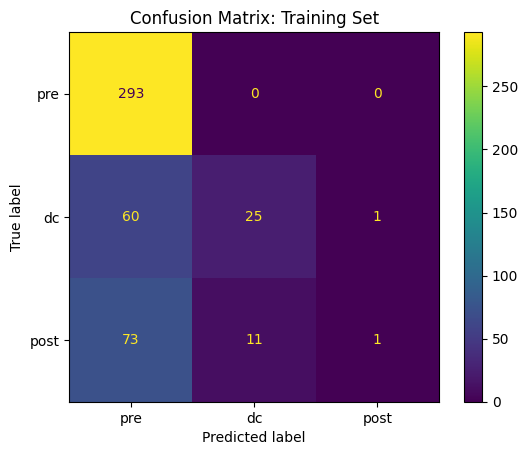

              precision    recall  f1-score   support

           0       0.69      1.00      0.82       293
           1       0.69      0.29      0.41        86
           2       0.50      0.01      0.02        85

    accuracy                           0.69       464
   macro avg       0.63      0.43      0.42       464
weighted avg       0.65      0.69      0.59       464



In [54]:
evaluate_labels(true_labels_train, pred_labels_train, 'Training Set')

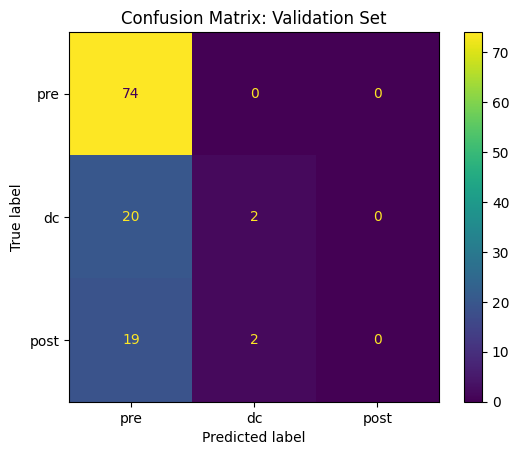

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        74
           1       0.50      0.09      0.15        22
           2       0.00      0.00      0.00        21

    accuracy                           0.65       117
   macro avg       0.38      0.36      0.32       117
weighted avg       0.51      0.65      0.53       117



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
evaluate_labels(true_labels_val, pred_labels_val, 'Validation Set')

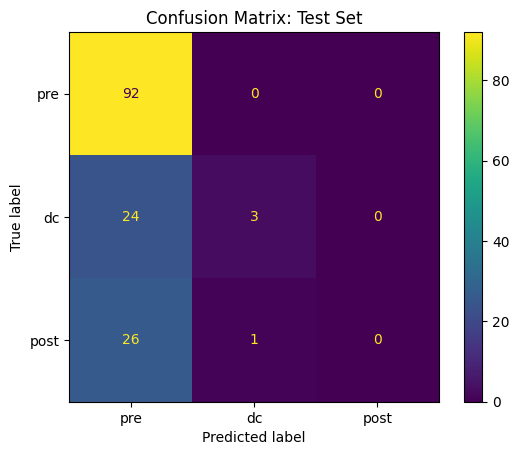

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        92
           1       0.75      0.11      0.19        27
           2       0.00      0.00      0.00        27

    accuracy                           0.65       146
   macro avg       0.47      0.37      0.33       146
weighted avg       0.55      0.65      0.53       146



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
evaluate_labels(true_labels_test, pred_labels_test, 'Test Set')

### Save dataset indices

In [60]:
train_indices[0:5]

[547, 44, 131, 218, 568]

In [62]:
import json
os.getcwd()

'/home/patrick/ssr'

In [63]:
with open('PSUH/train_indices.json', 'w') as f:
    json.dump(train_indices, f, indent=4)

In [64]:
with open('PSUH/val_indices.json', 'w') as f:
    json.dump(val_indices, f, indent=4)

In [65]:
with open('PSUH/test_indices.json', 'w') as f:
    json.dump(test_indices, f, indent=4)